In [1029]:
#%matplotlib inline
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

# UPDATE THE PATH BELOW TO THE CODE FOLDER


Write a test for this on simulated data. Where you have periodic responses

In [1030]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

In [1031]:
sys.path.append("/Users/yves/Downloads/jPCA-master/")
import jPCA

# Load stuff

In [1032]:
#These are the times (in units of the behaviour system bin running @1000Hz) at which spikes occurred

selected_session = 1

all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


#This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

#This is basically a big table (you can open it in excel) which contains
#relevant information about each time the animal poked one of the ports
task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

#
response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
#alternatively to change the time window


#not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
single_units = np.load(os.path.join(root_dir,'single_units.npy'))

In [1034]:
seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))

In [1035]:
graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
graph_type1 = task_event_df.loc[task_event_df['task_nr']==1]['graph_type'].values[0]
print(graph_type0,graph_type1)

loop loop


In [1036]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = n_states
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):
                
                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &    #task_nr was task
                                                (task_event_df['correct']==True) &    #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction) &
                                                (task_event_df['port_repeat']==False)
                                               ].index  
                ##if direction==1:
                #    print(port,task_event_df.loc[table_index-1])
                #print(len(table_index))
                #get the average
                firing_rate_maps[:,int(port),int(task),dix] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

In [1037]:
n_states = 9

In [1038]:
firing_rate_maps = get_task_responses(task_event_df,response_table)

In [1039]:
n_neurons, n_ports, n_tasks, n_directions = firing_rate_maps.shape

In [1040]:
spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))

In [1041]:
#here subtract the spatial terms
mds_frm = firing_rate_maps - spatial_map[:,:,None,None]

In [1042]:
mds_frm.shape

(209, 9, 2, 2)

In [1043]:
from sklearn.decomposition import PCA

In [1044]:
#mds_frm_flat = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])
#mds_frm_flat = np.hstack([mds_frm[:,:,0,0],mds_frm[:,:,0,1],mds_frm[:,:,1,0],mds_frm[:,:,1,1]])
mds_frm_flat = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])
print(mds_frm_flat.shape)

(209, 36)


In [ ]:
def run_jPCA_across_tasks(firing_rate_maps,seq0,seq1,n_permutations=1000,factor_out_space=True):
    
    """ The outcome measure is whether the rotational dynamics can explain more variance
        than chance where chance is obtained by shuffling the ports. This is the naive 
        one that works for loops
        
        How do we cross-validate here..???
        
        Arguments:
        =================
        
        
        firing_rate_maps:     np.array
        
        
        
    """
    
    
    spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))    
    #here subtract the spatial terms
    if factor_out_space:
        mds_frm = firing_rate_maps - spatial_map[:,:,None,None]
    mds_frm_flat = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])
    pca = PCA(n_components=6)
    mds_frm_flat = pca.fit_transform(mds_frm_flat.T).T
    #print(mds_frm_flat.shape)
    
    for transition_sequence in range(4):
        tansition_slice = slice(transition_sequence*9,transition_sequence*18)
        
        transition_set = mds_frm[:,transition_slice].T
        
        datas = [transition_set]
        
        times = list(range(datas[0].shape[0]))
        tstart = 0
        tend = datas[0].shape[0]-1
        
        
        out = jpca.fit(datas, times=times, 
                       tstart=tstart, tend=tend,
                       pca=False,
                       subtract_cc_mean=False,
                       align_axes_to_data=False)
        
        projected,full_data_var,pca_var_capt,jpca_var_capt,processed_datas = out
        
        





In [1171]:
slice(9,18)

slice(9, 18, None)

In [1172]:
pca = PCA(n_components=6)

In [1173]:
pca = PCA(n_components=6)
mds_frm_flat = pca.fit_transform(mds_frm_flat.T).T
print(mds_frm_flat.shape)

(6, 36)


In [1201]:
import jPCA
jpca = jPCA.jPCA.JPCA(num_jpcs=6)



In [1202]:
datas = [mds_frm_flat[:,:9].T,mds_frm_flat[:,9:18].T]
datas2 = [mds_frm_flat[:,18:27].T,mds_frm_flat[:,27:].T]


#datas = [mds_frm_flat[:,:9].T,mds_frm_flat[:,18:27].T]
#datas2 = [mds_frm_flat[:,9:18].T,mds_frm_flat[:,27:].T]

times = list(range(datas[0].shape[0]))
tstart = 0
tend = datas[0].shape[0]-1


In [1203]:
times

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [1204]:
datas = [mds_frm_flat[:,:9].T]

In [1205]:
datas = [datas[0].T[:,np.random.permutation(np.arange(9))].T]

In [1219]:
np.roll?

In [1217]:
(projected, 
 full_data_var,
 pca_var_capt,
 jpca_var_capt,processed_datas) = jpca.fit(datas, times=times, 
                                           tstart=tstart, tend=tend,
                                           pca=False,
                                           subtract_cc_mean=False,
                                           align_axes_to_data=False)





In [1218]:
jpca_var_capt

array([0., 0., 0., 0., 0., 0.])

In [1209]:
full_data_var

0.39886191880890426

In [1210]:
np.array(projected).shape

(1, 9, 6)

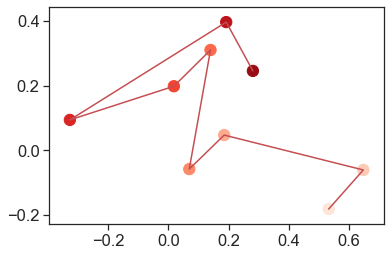

In [1216]:
dim1 = 3
dim2 = dim1+1
projected = np.array(projected)
plt.plot(projected[0,:,dim1],projected[0,:,dim2],color='r')
plt.scatter(projected[0,:,dim1],projected[0,:,dim2],c=seaborn.color_palette('Reds',n_colors=9),s=128)
#plt.plot(projected[1,:,dim1],projected[1,:,dim2],color='b')
#plt.scatter(projected[1,:,dim1],projected[1,:,dim2],c=seaborn.color_palette('Blues',n_colors=9),s=128)


In [1011]:
subtract_cc_mean = False

processed_datas2, full_data_var, pca_var_capt = \
jPCA.util.preprocess(datas2, times, tstart=tstart, tend=tend, pca=False,
               subtract_cc_mean=subtract_cc_mean, 
              )


In [1012]:
np.array(processed_datas2).shape

(2, 9, 6)

In [1013]:
#datas2 = 
a=jpca.project(processed_datas2)

In [1014]:
projected = a[0]

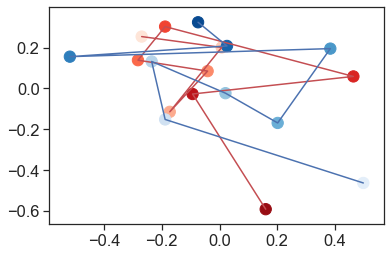

In [1015]:
#dim1 = 0
#dim2 = dim1+1
projected = np.array(projected)
plt.plot(projected[0,:,dim1],projected[0,:,dim2],color='r')
plt.scatter(projected[0,:,dim1],projected[0,:,dim2],c=seaborn.color_palette('Reds',n_colors=9),s=128)
plt.plot(projected[1,:,dim1],projected[1,:,dim2],color='b')
plt.scatter(projected[1,:,dim1],projected[1,:,dim2],c=seaborn.color_palette('Blues',n_colors=9),s=128)


In [637]:
a[1]

array([0.03154541, 0.03545225, 0.01689739, 0.03025847])